# Time Series Analysis: Monthly Air Passengers

This end-to-end time series analysis project forecasts monthly international air passenger numbers using SARIMA. The dataset contains monthly totals from 1949 to 1960. The project includes preprocessing, decomposition, stationarity checks, model selection, forecasting, and error evaluation.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [27]:
df = pd.read_csv("AirPassengers.csv", parse_dates=['Month'], index_col = ['Month'])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [29]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [31]:
df.isnull().sum()

#Passengers    0
dtype: int64

### Visualize time series

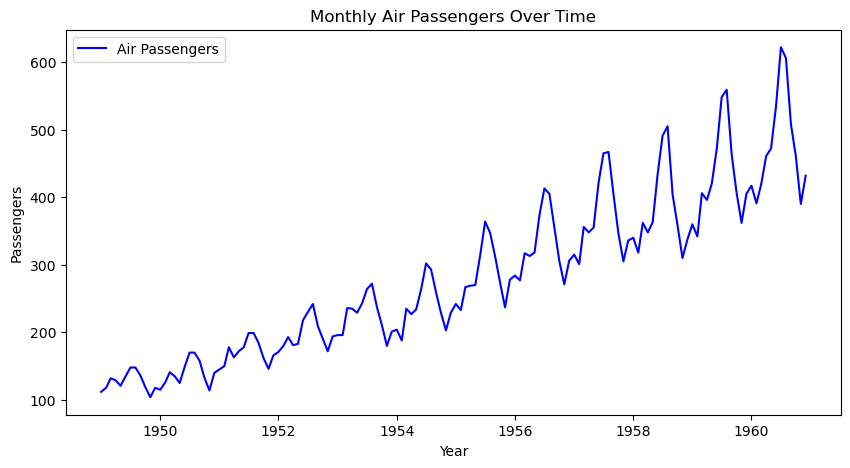

In [30]:
plt.figure(figsize=(10,5))
plt.plot(df, label = 'Air Passengers', color = 'blue')
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.title("Monthly Air Passengers Over Time")
plt.legend()
plt.show()

### Decompose Timse Series

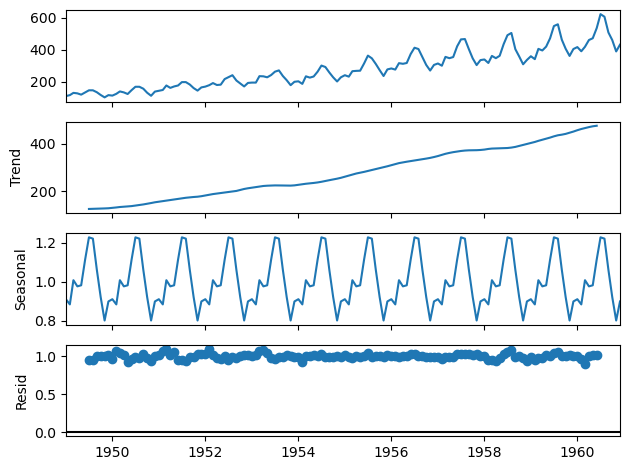

In [32]:
decomposed = seasonal_decompose(df, model = 'multiplicative')
decomposed.plot()
plt.show()

1. First plot -Original Time series- We can observe an upward trend and clear seasonality
2. Second plot - Trend Component - The trend is increasing, meaning that the number of passengers gradually rises over time
3. Third plot - Seasonal component - We see a consistent wave-like pattern, meaning passengers counts increase and decrease at similar times each year. 
4. Fourth plot - Residual component - The leftover part after removing trend and seasonality. If the residuals look random (which they do here), it means the model effectively captures the trend and seasonality. (If there were patterns in the residuals, we might need more advanced modeling)

### Check for Stationarity (ADF test)

In [33]:
result = adfuller(df['#Passengers'])
if result[1]<=0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")    

Data is not stationary


### Make Time Series Stationary (using Differencing)

In [34]:
df['Diff'] = df['#Passengers'].diff().diff().dropna()
result2 = adfuller(df['Diff'].dropna())

In [35]:
if result2[1]<=0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")    

Data is stationary


### Autocorrelation and Partial Autocorrelation (ACF&PACF)

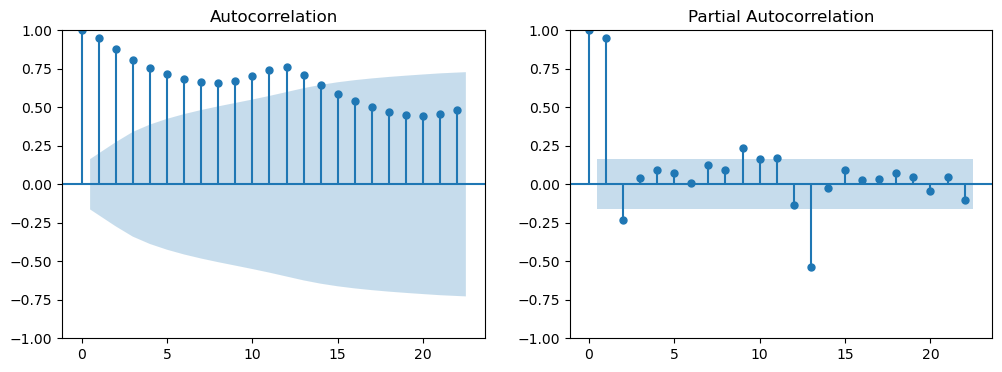

In [36]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
plot_acf(df['#Passengers'].dropna(), ax=ax[0])
plot_pacf(df['#Passengers'].dropna(), ax=ax[1])
plt.show()

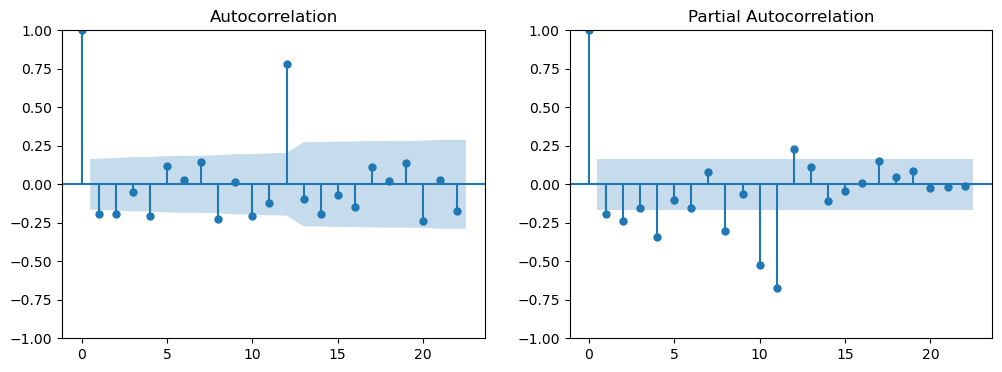

In [37]:
# After applying differencing
fig, ax = plt.subplots(1,2, figsize = (12,4))
plot_acf(df['Diff'].dropna(), ax=ax[0])
plot_pacf(df['Diff'].dropna(), ax=ax[1])
plt.show()

- ACF plot - There is significant peak at lag 12, which suggests strong seasonality (like 12 month cycle).

### Build and Fit ARIMA Model

In [39]:
model = ARIMA(df['#Passengers'], order=(2,1,2))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Sun, 13 Apr 2025   AIC                           1353.347
Time:                        00:32:05   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.059      0.000       1.645       1.725
ar.L2         -0.9548      0.017    -55.419      0.000      -0.989      -0.921
ma.L1         -1.8432      0.125    -14.790      0.0

### Forecasting with ARIMA

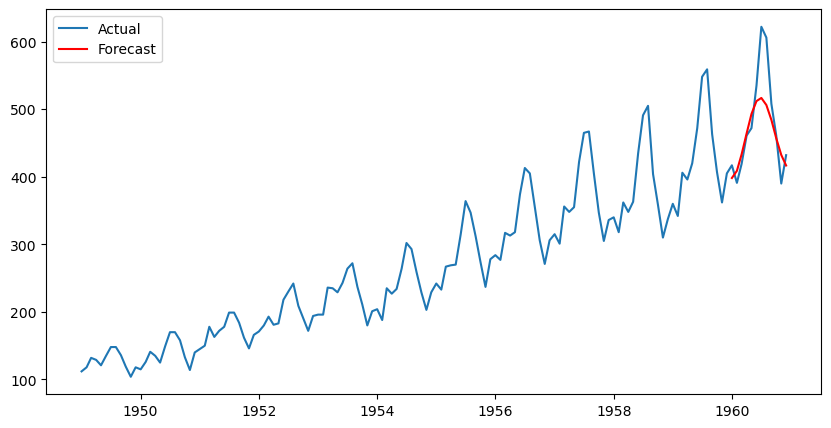

In [40]:
df['Forecast'] = result.predict(start=len(df)-12, end = len(df)+12, dynamic = True)

plt.figure(figsize = (10,5))
plt.plot(df["#Passengers"], label = 'Actual')
plt.plot(df['Forecast'], label = 'Forecast', color = 'red')
plt.legend()
plt.show()

### Using SARIMA for Seasonality

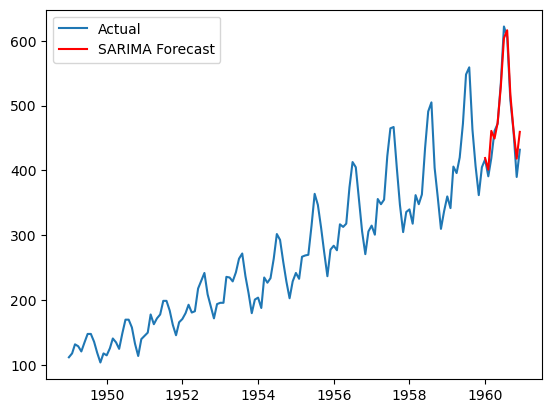

In [44]:
sarima_model = SARIMAX(df['#Passengers'], order = (1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()

df['SARIMA_Forecast'] = sarima_result.predict(start = len(df)-12, end = len(df)+12, dynamic = True)


plt.plot(df['#Passengers'], label = "Actual")
plt.plot(df['SARIMA_Forecast'], label = "SARIMA Forecast", color = 'red')
plt.legend()
plt.show()

In [45]:
print("ARIMA AIC:", result.aic)
print("SARIMA AIC:", sarima_result.aic)
print("ARIMA BIC:", result.bic)
print("SARIMA BIC:", sarima_result.bic)

ARIMA AIC: 1353.3466414584502
SARIMA AIC: 1022.298793640585
ARIMA BIC: 1368.1608646097498
SARIMA BIC: 1036.6747802565908


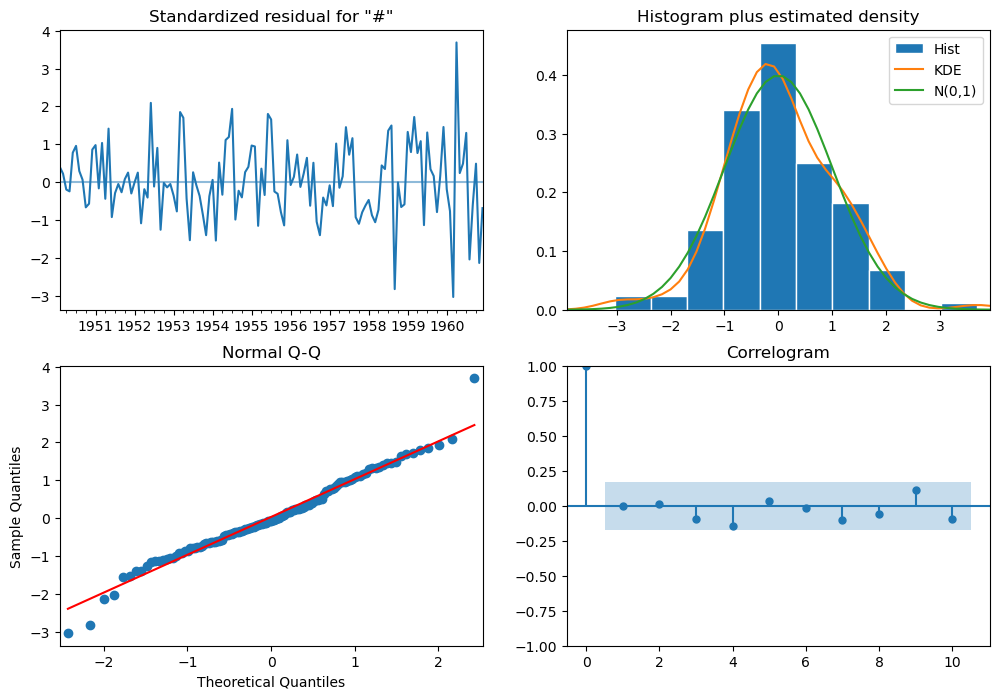

In [47]:
sarima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

#### Evaluate the model

In [48]:
actual_forecast_values = df['#Passengers'][-12: ] #Last 12 actual values
predicted_values = df['SARIMA_Forecast'][-12:] #Last 12 forecasted values

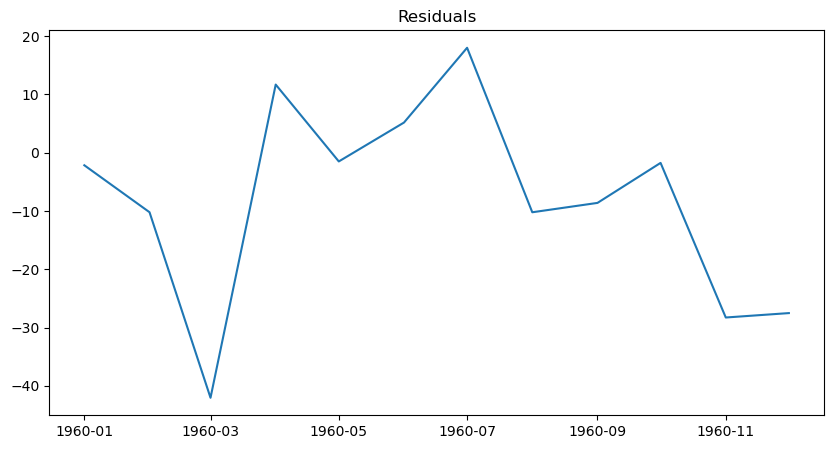

In [49]:
# Residual Analysis

residuals = actual_forecast_values - predicted_values

plt.figure(figsize= (10,5))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

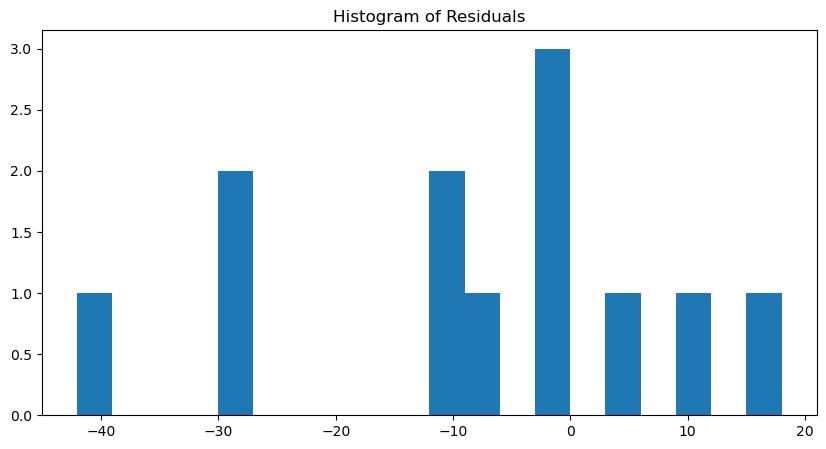

In [50]:
plt.figure(figsize = (10,5))
plt.hist(residuals, bins= 20)
plt.title('Histogram of Residuals')
plt.show()

In [52]:
# 2. Error Metrics
mse = mean_squared_error(actual_forecast_values, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_forecast_values, predicted_values)
mape = mean_absolute_percentage_error(actual_forecast_values, predicted_values)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

Mean Squared Error (MSE): 341.9621
Root Mean Squared Error (RMSE): 18.4922
Mean Absolute Error (MAE): 13.9266
Mean Absolute Percentage Error (MAPE): 0.0310


We assessed the performance of our SARIMA model using several metrics. The Mean Absolute Error (MAE) was approximately 13.93, and the Root Mean Squared Error (RMSE) was around 18.49. These figures indicate that, on average, our forecasted passenger numbers differed from the actual values by about 14 to 18 passengers. Importantly, the Mean Absolute Percentage Error (MAPE) was only 3.1%, which demonstrates that the model's predictions align very closely with the real data in percentage terms. These low error values suggest that the SARIMA model is a good fit for this data and appears capable of generating reliable forecasts for future trends in air passenger numbers.